# Imports

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob 
import os
import warnings
import networkx as nx
import matplotlib.colors as mcolors
from scipy.stats import pearsonr
import sklearn 
from sklearn.covariance import GraphicalLassoCV,GraphicalLasso
from networkx.generators.community import gaussian_random_partition_graph
from sklearn.model_selection import ValidationCurveDisplay
import scipy.stats as stats
from scipy.stats import ttest_ind
import nibabel as nib 
# import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import glob as glob
import math
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo


In [122]:
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.display.max_rows = None
pd.options.display.max_columns = None

plt.style.use('ggplot')

# I. Setup 
Seed the random number generator once, so the entire notebook is reproducible.

In [123]:
np.random.seed(3)

## 1: Load & Clean data
### A. Read ADNI data quartile csvs 
- These data have regional tau SUVRs, centiloid values, visit dates, and ID 
- (103, 228) in low 
- (107, 228) in med low 
- (100, 228) in med high 
- (101, 228) in high 


In [124]:
#adni 
adni_cent_low = pd.read_csv('./adni/adni_amy_tau_merged_cent_low_quartile.csv')
adni_cent_med_low = pd.read_csv('./adni/adni_amy_tau_merged_cent_med_low_quartile.csv')
adni_cent_med_high = pd.read_csv('./adni/adni_amy_tau_merged_cent_med_high_quartile.csv')
adni_cent_high = pd.read_csv('./adni/adni_amy_tau_merged_cent_high_quartile.csv')


### B. Read A4 data quartile csvs 
- These data have regional tau SUVRs, centiloid values, visit dates, and ID 
- (101, 277) in low 
- (86, 277) in med low 
- (94, 277) in med high
- (92, 277) in high

In [125]:
#a4 
a4_cent_low = pd.read_csv('./a4/a4_amy_tau_merged_cent_low_quartile.csv')
a4_cent_med_low = pd.read_csv('./a4/a4_amy_tau_merged_cent_med_low_quartile.csv')
a4_cent_med_high = pd.read_csv('./a4/a4_amy_tau_merged_cent_med_high_quartile.csv')
a4_cent_high = pd.read_csv('./a4/a4_adni_amy_tau_merged_cent_high_quartile.csv')

### C. Clean and Normalize data:


I. Check that there are no more regions with zero volume:

In [126]:
zero_present = (adni_cent_high == 0).any().any()
print(zero_present)

False


II. Drop `RID`, ` CENTILOIDS`, and `TRACER` we don't need that information to compute the graph. Only keep the tau suvr values for the graph

In [127]:
#function to drop non regions 
def drop_nonregions(df):
    df = df.drop(['RID','CENTILOIDS','TRACER'], axis=1)
    return df 

In [128]:
#appy function to all dfs 
#a4
a4_cent_low = drop_nonregions(a4_cent_low)
a4_cent_med_low = drop_nonregions(a4_cent_med_low)
a4_cent_med_high = drop_nonregions(a4_cent_med_high)
a4_cent_high = drop_nonregions(a4_cent_high)
#adni 
adni_cent_low = drop_nonregions(adni_cent_low)
adni_cent_med_low = drop_nonregions(adni_cent_med_low)
adni_cent_med_high = drop_nonregions(adni_cent_med_high)
adni_cent_high = drop_nonregions(adni_cent_high)

In [129]:
print(adni_cent_high.columns)

Index(['TRANSVERSETEMPORAL', 'SUPERIORTEMPORAL', 'INFERIORTEMPORAL',
       'FUSIFORM', 'POSTERIORCINGULATE', 'INSULA', 'PERICALCARINE', 'PUTAMEN',
       'PARAHIPPOCAMPAL', 'SUPERIORPARIETAL', 'LATERALOCCIPITAL',
       'INFERIORPARIETAL', 'CAUDALANTERIORCINGULATE', 'POSTCENTRAL', 'CAUDATE',
       'SUPRAMARGINAL', 'PRECENTRAL', 'TEMPORALPOLE', 'PARACENTRAL',
       'ISTHMUSCINGULATE', 'ACCUMBENS_AREA', 'LINGUAL', 'PALLIDUM', 'AMYGDALA',
       'ROSTRALANTERIORCINGULATE', 'BANKSSTS', 'CUNEUS', 'MIDDLETEMPORAL',
       'SUPERIORFRONTAL', 'PRECUNEUS'],
      dtype='object')


In [130]:
#check that it worked 
adni_cent_high.head(5)

,TRANSVERSETEMPORAL,SUPERIORTEMPORAL,INFERIORTEMPORAL,FUSIFORM,POSTERIORCINGULATE,INSULA,PERICALCARINE,PUTAMEN,PARAHIPPOCAMPAL,SUPERIORPARIETAL,LATERALOCCIPITAL,INFERIORPARIETAL,CAUDALANTERIORCINGULATE,POSTCENTRAL,CAUDATE,SUPRAMARGINAL,PRECENTRAL,TEMPORALPOLE,PARACENTRAL,ISTHMUSCINGULATE,ACCUMBENS_AREA,LINGUAL,PALLIDUM,AMYGDALA,ROSTRALANTERIORCINGULATE,BANKSSTS,CUNEUS,MIDDLETEMPORAL,SUPERIORFRONTAL,PRECUNEUS
0,1.136,1.726,1.960,1.446,1.447,1.557,1.638,1.402,1.582,1.639,1.598,1.692,1.400,1.467,1.298,1.540,1.402,2.605,1.387,1.557,2.485,1.314,1.548,2.119,1.574,1.539,1.426,2.280,1.466,1.474
1,1.035,1.530,2.097,2.332,1.559,1.325,1.283,1.750,1.801,2.073,2.520,1.881,1.238,1.318,1.222,1.525,1.284,1.885,1.338,1.444,1.471,1.935,1.679,1.593,1.169,1.477,2.215,1.790,1.393,1.803
2,1.075,1.877,2.818,2.349,1.784,1.583,1.259,1.969,2.120,1.792,1.551,2.302,1.310,1.378,1.885,1.853,1.373,2.853,1.289,1.787,2.468,1.276,2.224,1.727,1.246,1.648,1.616,2.564,1.535,1.785
3,1.255,1.492,1.819,1.528,1.510,1.484,1.476,1.509,1.511,1.699,1.712,1.654,1.540,1.575,1.567,1.681,1.508,1.499,1.614,1.573,1.619,1.478,1.906,1.276,1.191,1.510,1.735,1.735,1.624,1.653
4,1.357,1.681,2.117,2.606,1.492,1.428,1.344,1.880,1.718,2.090,3.603,2.026,1.426,1.480,1.772,1.575,1.360,1.896,1.452,1.505,1.675,1.969,1.417,2.948,1.362,1.968,1.996,1.950,1.496,1.603


In [158]:
print(adni_cent_high.columns)

Index(['TRANSVERSETEMPORAL', 'SUPERIORTEMPORAL', 'INFERIORTEMPORAL',
       'FUSIFORM', 'POSTERIORCINGULATE', 'INSULA', 'PERICALCARINE', 'PUTAMEN',
       'PARAHIPPOCAMPAL', 'SUPERIORPARIETAL', 'LATERALOCCIPITAL',
       'INFERIORPARIETAL', 'CAUDALANTERIORCINGULATE', 'POSTCENTRAL', 'CAUDATE',
       'SUPRAMARGINAL', 'PRECENTRAL', 'TEMPORALPOLE', 'PARACENTRAL',
       'ISTHMUSCINGULATE', 'ACCUMBENS_AREA', 'LINGUAL', 'PALLIDUM', 'AMYGDALA',
       'ROSTRALANTERIORCINGULATE', 'BANKSSTS', 'CUNEUS', 'MIDDLETEMPORAL',
       'SUPERIORFRONTAL', 'PRECUNEUS'],
      dtype='object')


III. Normalize the data
Center the data and scale them to have unit standard deviation

In [131]:
#function to center data and scale them, and makesure format is a dataframe 
def norm(df):
    scaled_df = StandardScaler().set_output(transform='pandas').fit_transform(df)
    return scaled_df 

In [132]:
#appy norm function to all dfs 
#a4
a4_cent_low_norm = norm(a4_cent_low)
a4_cent_med_low_norm = norm(a4_cent_med_low)
a4_cent_med_high_norm = norm(a4_cent_med_high)
a4_cent_high_norm = norm(a4_cent_high)
#adni 
adni_cent_low_norm = norm(adni_cent_low)
adni_cent_med_low_norm = norm(adni_cent_med_low)
adni_cent_med_high_norm = norm(adni_cent_med_high)
adni_cent_high_norm = norm(adni_cent_high)

In [133]:
#check that the output is normalized 
adni_cent_high_norm.head(5)

,TRANSVERSETEMPORAL,SUPERIORTEMPORAL,INFERIORTEMPORAL,FUSIFORM,POSTERIORCINGULATE,INSULA,PERICALCARINE,PUTAMEN,PARAHIPPOCAMPAL,SUPERIORPARIETAL,LATERALOCCIPITAL,INFERIORPARIETAL,CAUDALANTERIORCINGULATE,POSTCENTRAL,CAUDATE,SUPRAMARGINAL,PRECENTRAL,TEMPORALPOLE,PARACENTRAL,ISTHMUSCINGULATE,ACCUMBENS_AREA,LINGUAL,PALLIDUM,AMYGDALA,ROSTRALANTERIORCINGULATE,BANKSSTS,CUNEUS,MIDDLETEMPORAL,SUPERIORFRONTAL,PRECUNEUS
0,-0.407722,-0.294868,-0.649745,-0.925952,-0.486180,0.105948,0.796144,-0.677903,-0.757658,-0.549383,-0.742736,-0.651850,-0.172100,-0.421807,-0.364765,-0.629763,-0.400092,1.172190,-0.294801,-0.508116,1.751130,-0.693472,-0.275047,-0.001917,0.622418,-0.530561,-0.596989,-0.143804,-0.495869,-0.555259
1,-0.769264,-0.683394,-0.504554,0.172110,-0.319876,-0.573835,-0.253139,0.843904,-0.318133,-0.132637,0.131289,-0.485462,-0.647758,-0.766401,-0.672755,-0.647295,-0.681673,-0.358703,-0.488170,-0.651202,-0.205964,0.270049,0.205749,-0.823327,-0.551936,-0.585307,0.336776,-0.693244,-0.619397,-0.209086
2,-0.626079,0.004455,0.259554,0.193179,0.014216,0.182130,-0.324076,1.801593,0.322088,-0.402466,-0.787290,-0.114830,-0.436355,-0.627638,2.014051,-0.263922,-0.469294,1.699498,-0.681539,-0.216879,1.718318,-0.752432,2.206006,-0.614071,-0.328664,-0.434316,-0.372128,0.174646,-0.379111,-0.228025
3,0.018253,-0.758720,-0.799175,-0.824325,-0.392634,-0.107950,0.317316,-0.209991,-0.900152,-0.491768,-0.634668,-0.685303,0.238963,-0.172034,0.725357,-0.464959,-0.147146,-1.179432,0.601011,-0.487856,0.079687,-0.439016,1.038884,-1.318360,-0.488144,-0.556168,-0.231294,-0.754915,-0.228508,-0.366916
4,0.383374,-0.384071,-0.483358,0.511691,-0.419362,-0.272035,-0.072840,1.412395,-0.484711,-0.116313,1.157935,-0.357810,-0.095760,-0.391741,1.556119,-0.588854,-0.500316,-0.335315,-0.038291,-0.573961,0.187771,0.322802,-0.755842,1.292663,0.007694,-0.151760,0.077594,-0.513835,-0.445105,-0.419526


IV. Double checking there are no null values

In [134]:
def null_checker(df):
    null_count = df.isna().any().any()
    return null_count

In [135]:
#no null values
null_checker(adni_cent_high_norm)

False

## 2: Bootstrap samples
- We use bootstrapping (with replacement) before the graphical lasso cv. 
- start with just a4_cent_low_norm


A. Create 100 bootstrap samples for each dataframe 

In [136]:
num_bootstrap_samples = 100

bootstrap_precision_matrices = []
bootstrap_samples = []

for _ in tqdm(range(num_bootstrap_samples)):
    
    #sample with replacement
    bootstrap_sample = adni_cent_high_norm.sample(n=len(a4_cent_high_norm),replace=True).sort_index().reset_index(drop=True)
    
    bootstrap_samples.append(bootstrap_sample)

100%|██████████| 100/100 [00:00<00:00, 4902.35it/s]


In [137]:
#check length of first element in bootstrap samples list (should be 101 for 100 samples + header row)
len(bootstrap_samples[0])

92

B. Check for infinite and null values, the should both be false:

In [138]:
print(np.any(np.isinf(bootstrap_samples)))
print(bootstrap_sample.isna().any().any())

False
False


C. check datatypes 

if I give it alphas [1,10] it looks like it drops almost all of the connections 
   
How I can be evaluating how well my model is fitting the data?

2 matrices estimates (from graphical lasso and then the actual empirical) to do difference you could 

if I just want estimate of how well its performing 

D. Thoughts - should we reset index?
- use the sklearn sampler?

## 3: CV to select $L_1$ regularization

In [139]:
model = GraphicalLasso(alpha=0.1, max_iter=100, tol=1e-2, mode='cd',assume_centered=True,covariance=None) #if I predefine an alpha it will take less time 
model

GraphicalLasso(alpha=0.1, assume_centered=True, tol=0.01)

A. It looks like the model is very sensitive to the choice of $\alpha$, let's see what the sparsity looks like as a function of it

In [140]:
alphas = np.geomspace(0.1,0.9,64)
precision_sparsities = []
covariance_sparsities = []

for alpha in alphas: 
    
    model = GraphicalLasso(alpha=alpha, max_iter=200, tol=1e-2, mode='cd', assume_centered=True)
    model.fit(a4_cent_low_norm)

    precision_sparsities.append(np.count_nonzero(model.precision_)/(model.precision_.size))
    covariance_sparsities.append(np.count_nonzero(model.covariance_)/(model.covariance_.size))

B. Choosing $\alpha$ < 0.2 has no effect on the sparsity of the covariance matrix (there might still be some shrinkage though). We should choose the optimal value of $\alpha$ by looking at the cross validated performance of the estimator, and thinking about how much sparsity we want in the final graph.

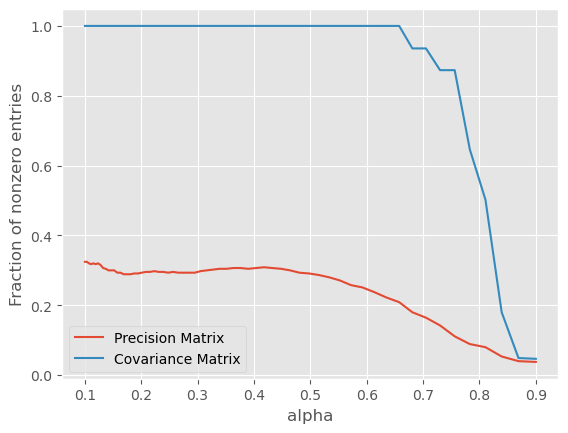

In [141]:
plt.plot(alphas,precision_sparsities,label="Precision Matrix")
plt.plot(alphas,covariance_sparsities,label="Covariance Matrix")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.legend()

In [142]:
model.get_params()

{'alpha': 0.9,
 'assume_centered': True,
 'covariance': None,
 'enet_tol': 0.0001,
 'eps': 2.220446049250313e-16,
 'max_iter': 200,
 'mode': 'cd',
 'tol': 0.01,
 'verbose': False}

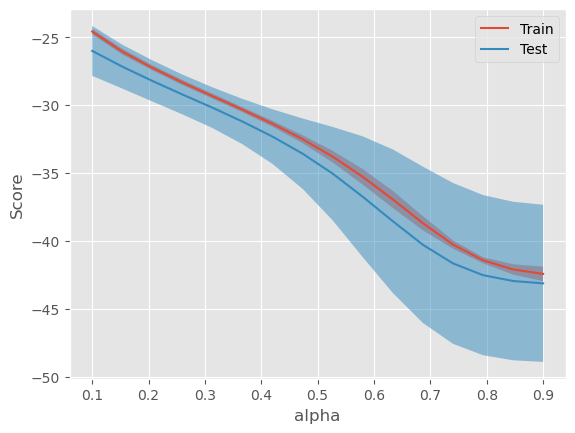

In [143]:
ValidationCurveDisplay.from_estimator(estimator=model,
                                      X=a4_cent_low_norm,
                                      y=None,
                                      cv=10,
                                      param_name='alpha',
                                      param_range=np.linspace(0.1,0.9,16),
                                      n_jobs=-1
                                     )

C. As expected, with increasing $\alpha$ our sparse approximation of the covariance matrix gets worse. 

- There's an inflection point around $\alpha = 0.5$, does it mean anything?
- At $\alpha=0.5$ the covariance matrix is still 90% filled, it might be a good idea to make it much more and then decrease alpha gradually if we cannot see any difference between the two groups.

# II. Train graphical model on bootstrapped sample 
- find score on each num bootstrap sample 

In [144]:
models = []

for bootstrap_sample in tqdm(bootstrap_samples):
    model = GraphicalLasso(alpha=0.7,max_iter=150, tol=1e-3) #if I predefine an alpha it will take less time 
    
    model.fit(bootstrap_sample)
    models.append(model) 

100%|██████████| 100/100 [00:00<00:00, 150.13it/s]


In [145]:
bootstrap_sample.head()

,TRANSVERSETEMPORAL,SUPERIORTEMPORAL,INFERIORTEMPORAL,FUSIFORM,POSTERIORCINGULATE,INSULA,PERICALCARINE,PUTAMEN,PARAHIPPOCAMPAL,SUPERIORPARIETAL,LATERALOCCIPITAL,INFERIORPARIETAL,CAUDALANTERIORCINGULATE,POSTCENTRAL,CAUDATE,SUPRAMARGINAL,PRECENTRAL,TEMPORALPOLE,PARACENTRAL,ISTHMUSCINGULATE,ACCUMBENS_AREA,LINGUAL,PALLIDUM,AMYGDALA,ROSTRALANTERIORCINGULATE,BANKSSTS,CUNEUS,MIDDLETEMPORAL,SUPERIORFRONTAL,PRECUNEUS
0,-0.407722,-0.294868,-0.649745,-0.925952,-0.486180,0.105948,0.796144,-0.677903,-0.757658,-0.549383,-0.742736,-0.651850,-0.172100,-0.421807,-0.364765,-0.629763,-0.400092,1.172190,-0.294801,-0.508116,1.751130,-0.693472,-0.275047,-0.001917,0.622418,-0.530561,-0.596989,-0.143804,-0.495869,-0.555259
1,-0.626079,0.004455,0.259554,0.193179,0.014216,0.182130,-0.324076,1.801593,0.322088,-0.402466,-0.787290,-0.114830,-0.436355,-0.627638,2.014051,-0.263922,-0.469294,1.699498,-0.681539,-0.216879,1.718318,-0.752432,2.206006,-0.614071,-0.328664,-0.434316,-0.372128,0.174646,-0.379111,-0.228025
2,-0.626079,0.004455,0.259554,0.193179,0.014216,0.182130,-0.324076,1.801593,0.322088,-0.402466,-0.787290,-0.114830,-0.436355,-0.627638,2.014051,-0.263922,-0.469294,1.699498,-0.681539,-0.216879,1.718318,-0.752432,2.206006,-0.614071,-0.328664,-0.434316,-0.372128,0.174646,-0.379111,-0.228025
3,0.018253,-0.758720,-0.799175,-0.824325,-0.392634,-0.107950,0.317316,-0.209991,-0.900152,-0.491768,-0.634668,-0.685303,0.238963,-0.172034,0.725357,-0.464959,-0.147146,-1.179432,0.601011,-0.487856,0.079687,-0.439016,1.038884,-1.318360,-0.488144,-0.556168,-0.231294,-0.754915,-0.228508,-0.366916
4,-0.013964,-0.483184,-0.717571,-0.577695,0.029065,-0.040557,0.580376,-0.288705,-0.490732,-0.384221,-0.503848,-0.582301,-0.078143,0.147121,-0.664650,-0.466128,-0.180554,-0.430995,0.198487,-0.528376,1.546542,-0.097672,0.510375,-0.323610,0.083085,-0.442263,-0.472723,-0.705578,-0.506022,-0.495284


In [146]:
#different metrics to calc 
#gpe, clus_coeff 
#density nx.density(G)
#eigenvector centrality nx.eigenvector_centrality(G) seems like its not a single value 
#assostivity coeff nx.degree_assortativity_coefficient(G) 
#diameter nx.diameter(G) -  Gives the diameter of the largest connected component in the graph, representing the longest shortest path between any pair of nodes. gave error 
#radius nx.radius - computes the radius of the largest connected compmenet gave error 
#number connected components nx.number_connected_components(G)

In [147]:
#graphical lasso cv not converging 
#can adjust the tolerance, regularization parameter alphas, change solver method, increase max iterations, or random seed 
#example 
#model = GraphicalLassoCV(tol=1e-3)  # Increase tolerance level
#alphas = [0.1, 1.0, 10.0]  # Example list of alpha values to search
#model = GraphicalLassoCV(alphas=alphas)

#model = GraphicalLassoCV(solver='graph_lasso')  # Try a different solver
#model = GraphicalLassoCV(max_iter=500)  # Increase maximum iterations
#model = GraphicalLassoCV(random_state=42)  # Set a random seed
#graphical lasso -  WITHOUT BOOTSTRAP  
#converges with 500 iterations 
#estimates the precision matrix of the data (inverse cov mat which models the partial correlations between vars)
#uses lasso penalty, during training the model iteratively updates the estimated precision matrix using current hyperparamter values until it converges to a set of values that minimize the loss function 
# model = GraphicalLassoCV(cv=5,max_iter=500) #cv=5 specifies 5-fold cross validation strategy to optimize model hyperparameters 
# model.fit(progs_norm)
#have 1 rv per node (volumes), find out the optimization details, theorteically estimating corr mat of vars 


#have data, then unconnected random var,s est cov mat, and this estimation has penalty to force very small numbers to be 0 (force some sparsity) then interpret the inverse cov matrix as an adjacency matrix, and then visualize as a graph 
#makes sense to trat as random var, they are connecte din some sense if they are correlated 

#drop the very small nunvbwers, l1 sets very small things to 0, choses hyper parater by cross validation 

## A. Single graphical model visualization
 - This visualization is showing the precision matrix of the last model fitted in the loop, which corresponds to the last bootstrapped sample in the bootstrap_samples list. The graph shows the estimated relationships (connections) between variables based on the precision matrix of that particular bootstrapped sample.
 - The node size in these visualizations is calcuated based on node_degrees which is the connectivity strength of each node in the network (degree centrality)
 - Nodes that are more connected (have more connections appear larger, indicating their importance of centrality to the network)
 - Node color is also based on node degree centrality. Nodes with lower degrees are assigned lighter shaded and nodes with higher degrees are assigned darker shades 
 - So the larger and darker nodes are the ones with the highest degree centrality (most connected)
 - In disease context I can make the argument that these 

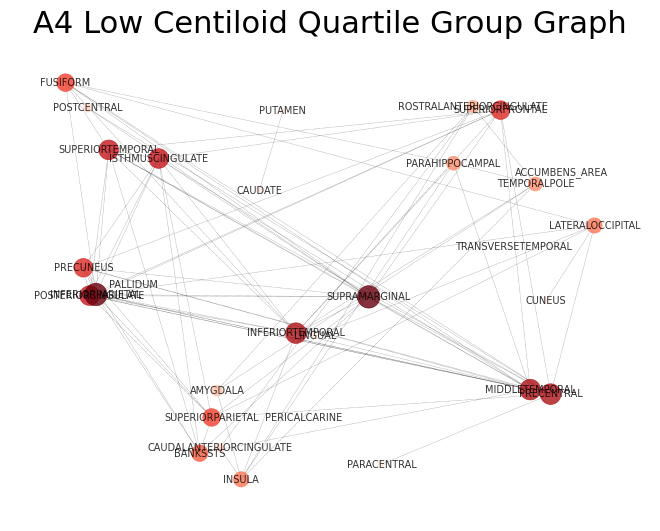

In [148]:
# just for graph visualization, doesn't work for bootstrapped because there's more than one pop graph 
# node size based on connectivity visualization 
# assigns node labels based on the column id 
# this doesn't work because it's the bootstrap sample list 
#It looks like it is working 
precision_matrix_p = model.precision_
np.fill_diagonal(precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 

G_prog = nx.Graph(precision_matrix_p)
#create a dictionary that maps old node labels to new node labels
node_labels = {i: label for i, label in enumerate(adni_cent_high.columns)}

#relabel the nodes in the graph using the dictionary
G_prog = nx.relabel_nodes(G_prog, node_labels)

# Assuming you already have precision_matrix_np and G_n_prog as in your code
# Calculate the node degrees (connectivity strength)
node_degrees = dict(G_prog.degree())

# Scale the node sizes based on node degrees
node_sizes = [20 * node_degrees[node] for node in G_prog.nodes()]

# Create a colormap for node colors based on node degrees
node_colors = list(node_degrees.values())

# Draw the graph with node sizes and colors
pos = nx.random_layout(G_prog)
nx.draw(
    G_prog,
    pos,
    with_labels=True,
    font_size=7,
    style="dotted",
    node_color=node_colors,
    cmap=plt.cm.Reds,
    node_size=node_sizes,
    alpha=0.8,
    width=0.3,
)

plt.title("A4 Low Centiloid Quartile Group Graph", fontsize=22)
plt.show()

# the random layout changes, to have the same one run the layout finctiopn first, choose what I want and then try it later 
# circular one might be good or spectral (bc it uses info on the degree of each node aware of hubs)
# since these are random seed rnadom generator to generate same layout 
# generate positions once and then pass same poisition dictioary 
# network x is generating citionary of 2d positins to draw function 
# draw in circle (then spot patterns that way)

## B. Average graphical model visualization for each group 
- I want a visualization that represents the average or consensus relationships across all bootstrapped models, you would need to compute some kind of aggregation or summary of the precision matrices from all the models in the models list.
- could be done by averaging the precision matrices element-wise or by using a statistical measure to combine them.
- could potentially combine the precision matrices from all the models and then create a graph based on this combined precision matrix. 
- The code currently generates a graph for just one model, the last one in the list.

100%|██████████| 100/100 [00:00<00:00, 148.66it/s]


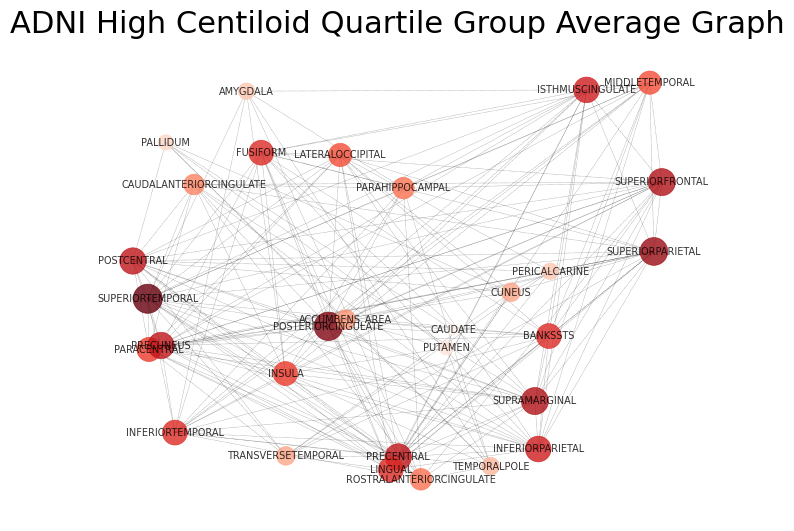

In [149]:
# Initialize an empty precision matrix accumulator
num_variables = bootstrap_samples[0].shape[1]
precision_matrix_accumulator = np.zeros((num_variables, num_variables))

# Loop through bootstrapped samples
for bootstrap_sample in tqdm(bootstrap_samples):
    model = GraphicalLasso(alpha=0.7, max_iter=150, tol=1e-3)
    model.fit(bootstrap_sample)
    # Add the precision matrix from the model to the accumulator element-wise
    precision_matrix_accumulator += model.precision_

# Normalize the accumulator by dividing by the number of bootstrapped samples
precision_matrix_avg = precision_matrix_accumulator / len(bootstrap_samples)

# Remove self-connections
np.fill_diagonal(precision_matrix_avg, 0)

# Create a graph based on the average precision matrix
# G_avg is an avg representation of the graphical structures from running the graphical model on 100 bootstrap samples 
#each indv 
G_avg = nx.Graph(precision_matrix_avg)

# Relabel nodes as in your original code
node_labels = {i: label for i, label in enumerate(adni_cent_high.columns)}
G_avg = nx.relabel_nodes(G_avg, node_labels)

# Calculate node degrees (connectivity strength)
node_degrees = dict(G_avg.degree())

# Scale node sizes based on node degrees
node_sizes = [20 * node_degrees[node] for node in G_avg.nodes()]

# Create a colormap for node colors based on node degrees
node_colors = list(node_degrees.values())

# Draw the graph with node sizes and colors
pos = nx.random_layout(G_avg)
nx.draw(
    G_avg,
    pos,
    with_labels=True,
    font_size=7,
    style="dotted",
    node_color=node_colors,
    cmap=plt.cm.Reds,
    node_size=node_sizes,
    alpha=0.8,
    width=0.3,
)
#(Average of 100 Models from 100 Bootstrap Samples)
plt.title("ADNI High Centiloid Quartile Group Average Graph", fontsize=22)
plt.show()



100%|██████████| 100/100 [00:00<00:00, 149.51it/s]


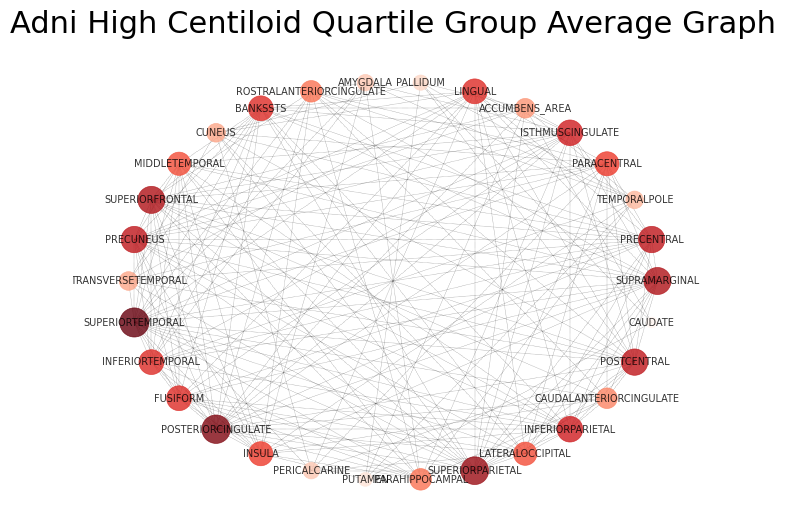

In [150]:
#trying spiral layout, it seems like they are in order of last is outermost on the spiral and so on 
# Initialize an empty precision matrix accumulator
num_variables = bootstrap_samples[0].shape[1]
precision_matrix_accumulator = np.zeros((num_variables, num_variables))

# Loop through bootstrapped samples
for bootstrap_sample in tqdm(bootstrap_samples):
    model = GraphicalLasso(alpha=0.7, max_iter=150, tol=1e-3)
    model.fit(bootstrap_sample)
    # Add the precision matrix from the model to the accumulator element-wise
    precision_matrix_accumulator += model.precision_

# Normalize the accumulator by dividing by the number of bootstrapped samples
precision_matrix_avg = precision_matrix_accumulator / len(bootstrap_samples)

# Remove self-connections
np.fill_diagonal(precision_matrix_avg, 0)

# Create a graph based on the average precision matrix
# G_avg is an avg representation of the graphical structures from running the graphical model on 100 bootstrap samples 
#each indv 
G_avg = nx.Graph(precision_matrix_avg)

# Relabel nodes as in your original code
node_labels = {i: label for i, label in enumerate(adni_cent_high.columns)}
G_avg = nx.relabel_nodes(G_avg, node_labels)

# Calculate node degrees (connectivity strength)
node_degrees = dict(G_avg.degree())

# Scale node sizes based on node degrees
node_sizes = [20 * node_degrees[node] for node in G_avg.nodes()]

# Create a colormap for node colors based on node degrees
node_colors = list(node_degrees.values())
#nodes with lower degrees are assigned lighter shaded and nodes with higher degrees are assigned darker shades 

# Draw the graph with fixed node positions using the "spring_layout" algorithm
pos = nx.shell_layout(G_avg)  # You can specify a seed for reproducibility
seed_value = 0
nx.draw(
    G_avg,
    pos,
    with_labels=True,
    font_size=7,
    style="dotted",
    node_color=node_colors,
    cmap=plt.cm.Reds,
    node_size=node_sizes,
    alpha=0.8,
    width=0.3,
)
#(Average of 100 Models from 100 Bootstrap Samples)
plt.title("Adni High Centiloid Quartile Group Average Graph", fontsize=22)
plt.show()

In [151]:
#calc metrics 
# terating through each bootsrap sample model, calculating the graph metrics, and then storing the metrics for eahc model in a dataframe 
metrics_data = []
#to get variance, 

#keep track of index with enumerate 
for model_num, model in enumerate(models,start=1):
    precision_matrix_p = model.precision_
    np.fill_diagonal(precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 
    G_prog = nx.Graph(precision_matrix_p)
    node_labels = {i: label for i, label in enumerate(adni_cent_high_norm.columns)}
    #relabel the nodes in the graph using the dictionary
    G_prog = nx.relabel_nodes(G_prog, node_labels)
    #now calculate the metrics and store them 
    gpe = nx.global_efficiency(G_prog) 
    clustering_coefficient = nx.average_clustering(G_prog)
    density = nx.density(G_prog)
    # eigen_cen = nx.eigenvector_centrality(G_prog)
    ass_coeff = nx.degree_assortativity_coefficient(G_prog)
    # diameter = nx.diameter(G_prog)
    # radius = nx.radius(G_prog)


    #create dictionary for current models data 
    metrics_dic = {
        'model_num': model_num,
        'gpe': gpe,
        'clus_coeff':clustering_coefficient,
        'density': density,
        'ass_coeff': ass_coeff
    }
    metrics_data.append(metrics_dic)


#turn the list of dictionaries with each model info into a df
metrics_data = pd.DataFrame(metrics_data)
# print(metrics_data.dtypes)
print(metrics_data)

    model_num       gpe  clus_coeff   density  ass_coeff
0           1  0.020690    0.177778  0.018391   0.000000
1           2  0.008046    0.000000  0.006897  -0.500000
2           3  0.220766    0.386190  0.094253   0.129154
3           4  0.411877    0.582461  0.236782   0.340664
4           5  0.088697    0.265556  0.055172   0.135818
5           6  0.376130    0.498438  0.209195   0.063537
6           7  0.000000    0.000000  0.000000        NaN
7           8  0.151724    0.322054  0.082759  -0.195617
8           9  0.334713    0.464187  0.190805   0.319110
9          10  0.364521    0.474858  0.170115   0.161279
10         11  0.373180    0.553975  0.204598  -0.033867
11         12  0.054368    0.155556  0.034483  -0.134454
12         13  0.377778    0.547971  0.232184  -0.089376
13         14  0.275479    0.430000  0.117241   0.041347
14         15  0.531609    0.654663  0.301149   0.260969
15         16  0.361111    0.524048  0.213793   0.222583
16         17  0.478927    0.68

/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/networkx/algorithms/assortativity/mixing.py:207: RuntimeWarning:

invalid value encountered in divide

/home/mlauber/miniconda3/envs/mci_mri_graph/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning:

invalid value encountered in scalar divide



In [152]:
#print(metrics_data)
#calc variance for each metric (which is col for each) like for mean 
#plot the variance for each metric/col across diff num samples (training curve)
# sklearn has training curve display 
# do it on estimator (graph lasso cv and training set) but do it on pop_ggm_code without bootstrap (good to have on poster)
# on bootstrapped data SSE ()

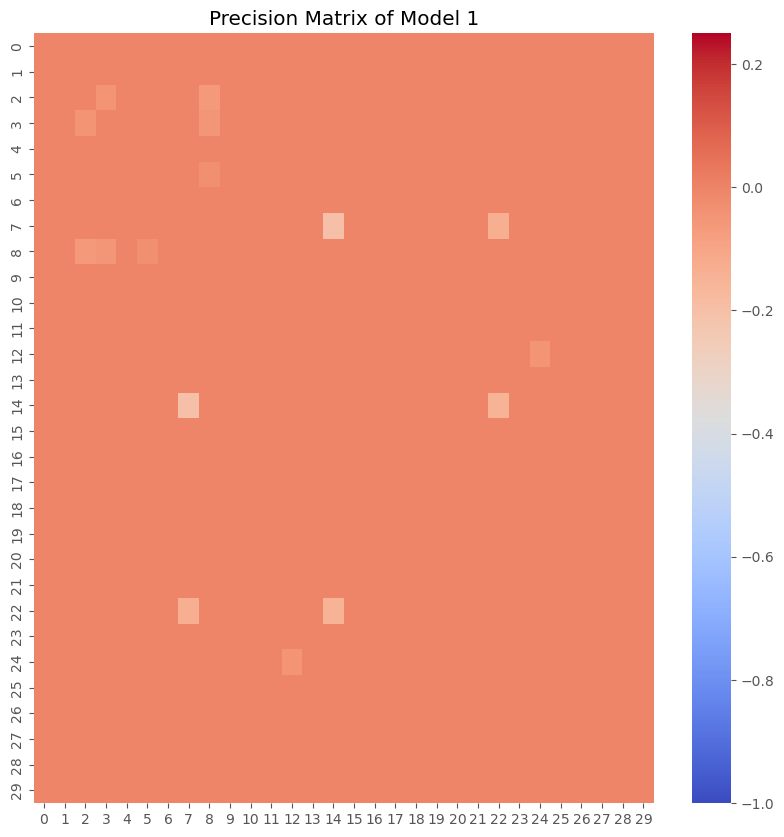

-0.20129433455087423 0.0


In [153]:
#heatmap of precision matrix (precision matrix is the inverse of the covariance matrix)

# Assuming models is your list of models
model_num = 0  # Change this to get the precision matrix of other models
precision_matrix = models[model_num].precision_

# Set the diagonal to zero if desired
np.fill_diagonal(precision_matrix, 0)

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(precision_matrix, cmap='coolwarm', annot=False, vmin=-1, vmax=.25)  # assuming values range from -1 to 1
plt.title(f'Precision Matrix of Model {model_num + 1}')
plt.show()
print(np.min(precision_matrix), np.max(precision_matrix))

#stronger parital correlation is red but what if 


In [154]:
# #bootstrap and plot stable 
# #bootstrap for stable adni 
# stab_num_bootstrap_samples = 5 
# stab_bootstrap_precision_matrices = []
# stab_bootstrap_samples = []
# for x in range(stab_num_bootstrap_samples):
#     #sample with replacement, randomstate =1 for reporoducibility 
#     stab_bootstrap_sample = stable_norm.sample(n=len(stable_norm),replace=True, random_state=1)
#     #append resamples df to a list 
#     stab_bootstrap_samples.append(stab_bootstrap_sample)

In [155]:
# stab_models.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/full_bootstrap_models_stab.csv')
#this doesn't work because the bootstrap is a list 

In [156]:
# #plot graph just for viualization doesn't work if there are more than one 
# #this doesn't work because the fraph is 
# precision_matrix_s = stab_model.precision_
# np.fill_diagonal(precision_matrix_s, 0) #removes self connections by replacing the diagnonal of matrix with 0 

# G_stab = nx.Graph(precision_matrix_s)
# #create a dictionary that maps old node labels to new node labels
# node_labels = {i: label for i, label in enumerate(stable_norm.columns)}

# #relabel the nodes in the graph using the dictionary
# G_stab = nx.relabel_nodes(G_stab, node_labels)

# #visualize the relabeled graph
# pos = nx.random_layout(G_stab)
# nx.draw(G_stab, pos, with_labels=True, font_size=7, style="dotted",
#         node_color=range(len(G_stab)), cmap=plt.cm.Blues,
#         node_size=150*len(G_stab)/154, alpha=.8, width=.3)
# plt.title("Stable MCI Population Graphical Model ADNI", fontsize=22)
# plt.show()

In [157]:
# Assuming stable_norm and stab_models are already defined somewhere

stab_metrics_data = []

for stab_model_num, stab_model in enumerate(stab_models):
    precision_matrix_stab = stab_model.precision_
    np.fill_diagonal(precision_matrix_stab, 0)  # removes self connections by replacing the diagonal of matrix with 0
    G_stab = nx.Graph(precision_matrix_stab)
    # create a dictionary that maps old node labels to new node labels
    stab_node_labels = {i: label for i, label in enumerate(stable_norm.columns)}
    # relabel the nodes in the graph using the dictionary
    G_stab = nx.relabel_nodes(G_stab, stab_node_labels)
    # now calculate the metrics and store them
    stab_gpe = nx.global_efficiency(G_stab)
    stab_clustering_coefficient = nx.average_clustering(G_stab)

    # Assuming you want to store metrics for stab (stability) models,
    # not prog (progression) models as shown in the second snippet
    stab_density = nx.density(G_stab)
    stab_ass_coeff = nx.degree_assortativity_coefficient(G_stab)

    # metrics dictionary
    stab_metrics_dic = {'model_num': stab_model_num,
                        'gpe': stab_gpe,
                        'clus_coeff': stab_clustering_coefficient,
                        'density': stab_density,
                        'ass_coeff': stab_ass_coeff
                        }

    stab_metrics_data.append(stab_metrics_dic)

stab_metrics_data = pd.DataFrame(stab_metrics_data)
stab_metrics_data.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/50_bootstrap_models_stab_metrics.csv')
print(stab_metrics_data)


NameError: name 'stab_models' is not defined

In [ ]:
#instead of calcing mean just calc from data instead 
#add col where the p val is greater than .05

# Initialize lists or a DataFrame to store your results
cols = []
p_values = []
t_stats = []

for col in metrics_data.columns:  
    if col != 'model_num':
    # Get data for this brain region from both datasets
        progs_data = metrics_data[col]
        stab_data = stab_metrics_data[col]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(progs_data, stab_data, equal_var=False)  # Assuming variance might not be equal
        
        # Store results
        cols.append(col)
        t_stats.append(t_stat)
        p_values.append(p_val)

    # Combine results into a DataFrame for easy viewing and further analysis
    results_df = pd.DataFrame({
        'Brain Region': cols,
        'T-Statistic': t_stats,
        'P-Value': p_values
})

# Adding the Significant column based on the P-Value
results_df['Significant'] = results_df['P-Value'] < 0.05

# Display or save the results
print(results_df)
# Optionally save to a CSV file
# results_df.to_csv('t_test_results.csv', index=False)

#the resulting negative t stats mean the progs have lower volume than the stab which is good 
results_df.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/50_bootstrap_models_ttest.csv')


  Brain Region  T-Statistic       P-Value  Significant
0          gpe     4.459436  1.377351e-05         True
1   clus_coeff   -24.185478  5.628139e-56         True
2      density   -17.855201  2.327898e-42         True
3    ass_coeff    -8.512191  1.000996e-14         True


# Interpreting Results 

In [ ]:
# Check that all dataframes have the same datatypes for each column
datatypes = nacc_bootstrap_samples[0].dtypes  # Get datatypes of the first dataframe
same_datatypes = all((df.dtypes == datatypes).all() for df in nacc_bootstrap_samples)

print(f'All dataframes have the same datatypes for each column: {same_datatypes}')


All dataframes have the same datatypes for each column: True


In [ ]:


# Assuming nacc_bootstrap_samples is your list of DataFrames
for i, df in enumerate(nacc_bootstrap_samples):
    if df.isnull().values.any():
        print(f'NaN values found in DataFrame at index {i}')
    else:
        print(f'No NaN values found in DataFrame at index {i}')

# If you want to see the total count of NaN values across all DataFrames:
total_nan_count = sum(df.isnull().sum().sum() for df in nacc_bootstrap_samples)
print(f'Total NaN count across all DataFrames: {total_nan_count}')


No NaN values found in DataFrame at index 0
No NaN values found in DataFrame at index 1
No NaN values found in DataFrame at index 2
No NaN values found in DataFrame at index 3
No NaN values found in DataFrame at index 4
No NaN values found in DataFrame at index 5
No NaN values found in DataFrame at index 6
No NaN values found in DataFrame at index 7
No NaN values found in DataFrame at index 8
No NaN values found in DataFrame at index 9
No NaN values found in DataFrame at index 10
No NaN values found in DataFrame at index 11
No NaN values found in DataFrame at index 12
No NaN values found in DataFrame at index 13
No NaN values found in DataFrame at index 14
No NaN values found in DataFrame at index 15
No NaN values found in DataFrame at index 16
No NaN values found in DataFrame at index 17
No NaN values found in DataFrame at index 18
No NaN values found in DataFrame at index 19
No NaN values found in DataFrame at index 20
No NaN values found in DataFrame at index 21
No NaN values found 

In [ ]:
import pandas as pd
import numpy as np

# Assuming nacc_bootstrap_samples is your list of DataFrames
for i, df in enumerate(nacc_bootstrap_samples):
    if np.isinf(df).values.any():
        print(f'Infinite values found in DataFrame at index {i}')
    else:
        print(f'No infinite values found in DataFrame at index {i}')

# If you want to see the total count of infinite values across all DataFrames:
total_inf_count = sum(np.isinf(df).sum().sum() for df in nacc_bootstrap_samples)
print(f'Total infinite count across all DataFrames: {total_inf_count}')


No infinite values found in DataFrame at index 0
No infinite values found in DataFrame at index 1
No infinite values found in DataFrame at index 2
No infinite values found in DataFrame at index 3
No infinite values found in DataFrame at index 4
No infinite values found in DataFrame at index 5
No infinite values found in DataFrame at index 6
No infinite values found in DataFrame at index 7
No infinite values found in DataFrame at index 8
No infinite values found in DataFrame at index 9
No infinite values found in DataFrame at index 10
No infinite values found in DataFrame at index 11
No infinite values found in DataFrame at index 12
No infinite values found in DataFrame at index 13
No infinite values found in DataFrame at index 14
No infinite values found in DataFrame at index 15
No infinite values found in DataFrame at index 16
No infinite values found in DataFrame at index 17
No infinite values found in DataFrame at index 18
No infinite values found in DataFrame at index 19
No infinit

In [ ]:
# for index, value in enumerate(nacc_bootstrap_samples):
#     if math.isnan(value):
#         print(f'NaN found at index {index}')

In [ ]:
# #check for nan or inf values - dont need anymore since I fixed it 

# #I don't need to use this because the 100 samples + random seed 3 is good without it 
# nacc_models = []
# for nacc_bootstrap_sample in tqdm(nacc_bootstrap_samples):
#     if nacc_bootstrap_sample.isnull().values.any() or np.isinf(nacc_bootstrap_sample).values.any():
#         print('NaN or Inf found')
#     nacc_model = GraphicalLassoCV(cv=2,max_iter=50, tol=1e-3)
#     nacc_model.fit(nacc_bootstrap_sample)
#     nacc_models.append(nacc_model)

# #try logging 
# import logging
# logging.basicConfig(level=logging.INFO)


# nacc_models = []
# for idx, nacc_bootstrap_sample in enumerate(tqdm(nacc_bootstrap_samples)):
#     # Check for NaN/Inf values
#     if nacc_bootstrap_sample.isnull().values.any() or np.isinf(nacc_bootstrap_sample).values.any():
#         logging.info(f'NaN or Inf found in sample {idx}')

#     # Try to fit the model
#     #try and except block structure 
#     try:
#         nacc_model = GraphicalLassoCV(cv=2, max_iter=50, tol=1e-3)
#         nacc_model.fit(nacc_bootstrap_sample)
#         nacc_models.append(nacc_model)
#     except ValueError as e:
#         logging.error(f'Error encountered in sample {idx}: {e}')
#         logging.error(f'Data: {nacc_bootstrap_sample}')



In [ ]:
# # need anymore I fixed the issue 
# import logging
# from tqdm import tqdm
# import pandas as pd
# from sklearn.covariance import GraphicalLassoCV

# logging.basicConfig(level=logging.INFO)

# nacc_models = []
# for idx, nacc_bootstrap_sample in enumerate(tqdm(nacc_bootstrap_samples)):
#     # Locate NaN and Inf values
#     nan_locations = nacc_bootstrap_sample.isnull().stack()[lambda x: x]
#     inf_locations = nacc_bootstrap_sample.isin([np.inf, -np.inf]).stack()[lambda x: x]

#     if not nan_locations.empty or not inf_locations.empty:
#         logging.info(f'NaN or Inf found in sample {idx}')
#         for location in nan_locations.index:
#             logging.info(f'NaN found at row {location[0]}, column {location[1]}')
#         for location in inf_locations.index:
#             logging.info(f'Inf found at row {location[0]}, column {location[1]}')

#     # Try to fit the model
#     try:
#         nacc_model = GraphicalLassoCV(cv=2, max_iter=50, tol=1e-3)
#         nacc_model.fit(nacc_bootstrap_sample)
#         nacc_models.append(nacc_model)
#     except ValueError as e:
#         logging.error(f'Error encountered in sample {idx}: {e}')
#         logging.error(f'Data: {nacc_bootstrap_sample}')


In [ ]:
#so there is one model that is throwing off the whole code in this 
print(len(nacc_models))

100


In [ ]:
#calc metrics - I think it was calcing the adni prog one (but they still look the same)
# iterating through each bootsrap sample model, calculating the graph metrics, and then storing the metrics for eahc model in a dataframe 
nacc_metrics_data = []

#keep track of index with enumerate 
for nacc_model_num, nacc_model in enumerate(nacc_models,start=1):
    nacc_precision_matrix_p = nacc_model.precision_
    np.fill_diagonal(nacc_precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 
    nacc_G_prog = nx.Graph(nacc_precision_matrix_p)
    nacc_node_labels = {i: label for i, label in enumerate(nacc_progs_norm.columns)}
    #relabel the nodes in the graph using the dictionary
    nacc_G_prog = nx.relabel_nodes(nacc_G_prog, nacc_node_labels)
    #now calculate the metrics and store them 
    nacc_gpe = nx.global_efficiency(nacc_G_prog) 
    nacc_clustering_coefficient = nx.average_clustering(nacc_G_prog)
    nacc_density = nx.density(nacc_G_prog)
    # eigen_cen = nx.eigenvector_centrality(G_prog)
    nacc_ass_coeff = nx.degree_assortativity_coefficient(nacc_G_prog)
    # diameter = nx.diameter(G_prog)
    # radius = nx.radius(G_prog)


    #create dictionary for current models data 
    nacc_metrics_dic = {
        'model_num': nacc_model_num,
        'gpe': nacc_gpe,
        'clus_coeff':nacc_clustering_coefficient,
        'density': nacc_density,
        'ass_coeff': nacc_ass_coeff
    }
    nacc_metrics_data.append(nacc_metrics_dic)


#turn the list of dictionaries with each model info into a df
nacc_metrics_data = pd.DataFrame(nacc_metrics_data)
nacc_metrics_data.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/full_bootstrap_models_prog_metrics_nacc.csv')
# print(metrics_data.dtypes)
print(nacc_metrics_data.shape)

(100, 5)


In [ ]:
#nacc_gmv_stab
#run bootstrap for stable df 
# np.random.seed(3)
nacc_stab_num_bootstrap_samples = 50
nacc_stab_bootstrap_precision_matrices = []
nacc_stab_bootstrap_samples = []
for x in range(nacc_stab_num_bootstrap_samples):
    #sample with replacement, randomstate =1 for reporoducibility 
    nacc_stab_bootstrap_sample = stable_norm.sample(n=len(stable_norm),replace=True)
    #append resamples df to a list 
    nacc_stab_bootstrap_samples.append(nacc_stab_bootstrap_sample)

In [ ]:
#run graphical model on bootstrapped sample 
nacc_stab_models = []
for nacc_stab_bootstrap_sample in tqdm(nacc_stab_bootstrap_samples):
    #if I give it alphas [1,10] it looks like it drops almost all of the connections 
    
    nacc_stab_model = GraphicalLassoCV(cv=5,max_iter=50,tol=1e-3)
    nacc_stab_model.fit(nacc_stab_bootstrap_sample)
    nacc_stab_models.append(nacc_stab_model) 

  0%|          | 0/100 [00:00<?, ?it/s]/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:273: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
  1%|          | 1/100 [00:05<09:08,  5.54s/it]/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:272: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/

In [ ]:
# Assuming stable_norm and stab_models are already defined somewhere

nacc_stab_metrics_data = []

for nacc_model_num, nacc_stab_model in enumerate(nacc_stab_models):
    nacc_precision_matrix_stab = nacc_stab_model.precision_
    np.fill_diagonal(nacc_precision_matrix_stab, 0)  # removes self connections by replacing the diagonal of matrix with 0
    nacc_G_stab = nx.Graph(nacc_precision_matrix_stab)
    # create a dictionary that maps old node labels to new node labels
    naccstab_node_labels = {i: label for i, label in enumerate(nacc_stable_norm.columns)}
    # relabel the nodes in the graph using the dictionary
    nacc_G_stab = nx.relabel_nodes(nacc_G_stab, naccstab_node_labels)
    # now calculate the metrics and store them
    nacc_stab_gpe = nx.global_efficiency(nacc_G_stab)
    nacc_stab_clustering_coefficient = nx.average_clustering(nacc_G_stab)

    # Assuming you want to store metrics for stab (stability) models,
    # not prog (progression) models as shown in the second snippet
    nacc_stab_density = nx.density(nacc_G_stab)
    nacc_stab_ass_coeff = nx.degree_assortativity_coefficient(nacc_G_stab)

    # metrics dictionary
    nacc_stab_metrics_dic = {'model_num': nacc_model_num,
                        'gpe': nacc_stab_gpe,
                        'clus_coeff': nacc_stab_clustering_coefficient,
                        'density': nacc_stab_density,
                        'ass_coeff': nacc_stab_ass_coeff
                        }

    nacc_stab_metrics_data.append(nacc_stab_metrics_dic)

nacc_stab_metrics_data = pd.DataFrame(nacc_stab_metrics_data)
nacc_stab_metrics_data.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/50_bootstrap_models_stab_metrics_nacc.csv')
print(nacc_stab_metrics_data)


    model_num       gpe  clus_coeff   density  ass_coeff
0           0  0.467661    0.409867  0.117740   0.230581
1           1  0.462437    0.432026  0.119539   0.185521
2           2  0.479908    0.392549  0.115836   0.189562
3           3  0.478471    0.390108  0.117529   0.213140
4           4  0.472795    0.388837  0.119221   0.251775
5           5  0.479869    0.410742  0.118587   0.188697
6           6  0.475600    0.376136  0.120808   0.267426
7           7  0.468026    0.396291  0.117211   0.224252
8           8  0.485735    0.372549  0.120702   0.176863
9           9  0.481422    0.406232  0.119539   0.163524
10         10  0.473791    0.393821  0.119645   0.225369
11         11  0.483372    0.376420  0.121126   0.220724
12         12  0.465711    0.421243  0.123453   0.186581
13         13  0.470424    0.375687  0.118375   0.274405
14         14  0.475870    0.392994  0.121549   0.232506
15         15  0.485290    0.406077  0.117211   0.219178
16         16  0.483007    0.39

In [ ]:
#
print(nacc_metrics_data.shape)
print(nacc_stab_metrics_data.shape)

(100, 5)
(100, 5)


In [ ]:
#nacc t test 
#instead of calcing mean just calc from data instead 
#add col where the p val is greater than .05

# Initialize lists or a DataFrame to store your results
cols = []
p_values = []
t_stats = []

# Note: The dataframe should be adni_gmv_progs, not adni_gmv_prog
for col in nacc_metrics_data.columns:  
    if col != 'model_num':
    # Get data for this brain region from both datasets
        nacc_progs_data = nacc_metrics_data[col]
        nacc_stab_data = nacc_stab_metrics_data[col]
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(nacc_progs_data, nacc_stab_data, equal_var=False)  # Assuming variance might not be equal
        
        # Store results
        cols.append(col)
        t_stats.append(t_stat)
        p_values.append(p_val)

    # Combine results into a DataFrame for easy viewing and further analysis
    nacc_results_df = pd.DataFrame({
        'Brain Region': cols,
        'T-Statistic': t_stats,
        'P-Value': p_values
})

# Adding the Significant column based on the P-Value
nacc_results_df['Significant'] = nacc_results_df['P-Value'] < 0.05

# Display or save the results
print("Nacc t test results between nacc prog and nacc stab")
print(nacc_results_df)
# Optionally save to a CSV file
# results_df.to_csv('t_test_results.csv', index=False)

#The results previously have been saved so I could even just load them 
#the resulting negative t stats mean the progs have lower volume than the stab which is good 
nacc_results_df.to_csv('/data2/MRI_PET_DATA/graph/csvs/bootstrap_models_and_metrics/50_bootstrap_models_ttest_nacc.csv')


Nacc t test results between nacc prog and nacc stab
  Brain Region  T-Statistic       P-Value  Significant
0          gpe   -11.130935  2.870134e-19         True
1   clus_coeff    -2.696797  7.854546e-03         True
2      density    -9.305936  2.348927e-15         True
3    ass_coeff    -8.811971  8.721287e-15         True


In [ ]:
print("Adni t test results between adni prog and adni stab")
print(results_df)
#andi and nacc results are the exact same so need to figure out why they are not 

Adni t test results between adni prog and adni stab
  Brain Region  T-Statistic       P-Value  Significant
0          gpe    -6.349198  3.268807e-09         True
1   clus_coeff   -22.606128  9.647343e-57         True
2      density   -27.292662  1.028930e-63         True
3    ass_coeff    -5.030910  1.270020e-06         True
